In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch import nn

In [3]:
import math
import matplotlib.pyplot as plt

In [5]:
import torchvision
import torchvision.transforms as transforms

In [6]:
torch.manual_seed(111)

In [7]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [8]:
print(device)

cuda


# Prepare the training data

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

**To perform the conversions to the data, we need to define the transforms**

1. **ToTensor() converts the data into tensor**
2. **Normalize() subtracts the value of data by the first parameter and divide by the second parameter**

**Load the train dataset**

In [10]:
train_set = torchvision.datasets.MNIST(root='.',train=True,download=True,transform=transform)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
batch_size=32

train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)

In [12]:
train_loader

tensor(6)
tensor(7)
tensor(2)
tensor(9)
tensor(3)
tensor(6)
tensor(6)
tensor(3)
tensor(0)
tensor(3)
tensor(8)
tensor(1)
tensor(3)
tensor(0)
tensor(8)
tensor(4)


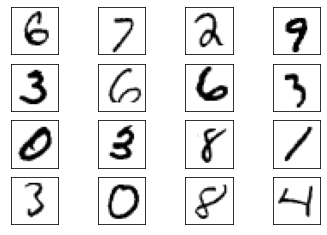

In [15]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    print(mnist_labels[i])
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    
    plt.xticks([])
    plt.yticks([])

# Discriminator

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

**In the forward method, we converts the image shape,by 32 × 1 × 28 × 28 into 32 × 784 where 32 is the batch size**

In [17]:
discriminator=Discriminator().to(device=device)

# Generator

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

**Here we give the 100 dimensional data and the model() returns the 784 dimensional data and converting into 28x28 image**

In [19]:
generator=Generator().to(device=device)

# Train the models

In [20]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

In [21]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [24]:
for epoch in range(num_epochs):
    for n,(real_samples,mnist_labels) in enumerate(train_loader):
        
        #Data for training the discriminator(real & latentspace samples)
        real_samples=real_samples.to(device=device)
        real_sample_labels=torch.ones((batch_size,1)).to(device=device)
        
        #Taking random 100 coefficients as samples
        latent_space_samples=torch.randn((batch_size,100)).to(device=device)
        
        #Passing random points to the generator
        generated_samples=generator(latent_space_samples)
        #As they are generated samples, giving the labels as 0
        generated_sample_labels=torch.zeros((batch_size,1)).to(device=device)
        
        #Creating all samples
        all_samples=torch.cat((real_samples,generated_samples))
        all_sample_labels=torch.cat((real_sample_labels,generated_sample_labels))
        
        
        
        #Training the discriminator
        discriminator.zero_grad()   #in order to accumulate the gradients to zero at every step
        output_discriminator=discriminator(all_samples)
        loss_discriminator=loss_function(output_discriminator,all_sample_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        
        #Data for training the generator
        latent_space_samples=torch.randn((batch_size,100)).to(device=device)
        
        
        #Training the generator
        generator.zero_grad()
        generated_samples=generator(latent_space_samples)
        output_discriminator_generated=discriminator(generated_samples)
        loss_generator=loss_function(output_discriminator_generated,real_sample_labels)
        loss_generator.backward()
        optimizer_generator.step()
        
        #To print the loss
        if n==batch_size-1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            plt.show(epoch,loss_discriminator)
            plt.show(epoch,loss_generator)
        

Epoch: 0 Loss D.: 0.03851284831762314
Epoch: 0 Loss G.: 5.781408309936523
Epoch: 1 Loss D.: 0.020009560510516167
Epoch: 1 Loss G.: 5.762503623962402
Epoch: 2 Loss D.: 0.011667277663946152
Epoch: 2 Loss G.: 4.783571720123291
Epoch: 3 Loss D.: 0.16279840469360352
Epoch: 3 Loss G.: 4.422273635864258
Epoch: 4 Loss D.: 0.1785421520471573
Epoch: 4 Loss G.: 4.035702705383301
Epoch: 5 Loss D.: 0.09576615691184998
Epoch: 5 Loss G.: 5.017132759094238
Epoch: 6 Loss D.: 0.11350148171186447
Epoch: 6 Loss G.: 3.6147875785827637
Epoch: 7 Loss D.: 0.11039786040782928
Epoch: 7 Loss G.: 3.525038003921509
Epoch: 8 Loss D.: 0.06438666582107544
Epoch: 8 Loss G.: 8.456087112426758
Epoch: 9 Loss D.: 0.10736550390720367
Epoch: 9 Loss G.: 3.4518468379974365
Epoch: 10 Loss D.: 0.28523603081703186
Epoch: 10 Loss G.: 2.7372426986694336
Epoch: 11 Loss D.: 0.22909808158874512
Epoch: 11 Loss G.: 2.0091161727905273
Epoch: 12 Loss D.: 0.46545809507369995
Epoch: 12 Loss G.: 1.6640576124191284
Epoch: 13 Loss D.: 0.43015

# Check samples generated by Generator

In [25]:
latent_space_sample=torch.randn((batch_size,100)).to(device=device)
generator_samples=generator(latent_space_sample)

In [27]:
type(generator_samples)

torch.Tensor

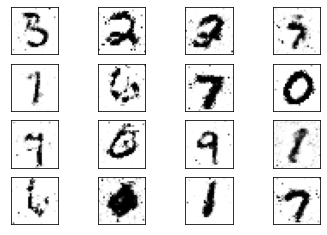

In [26]:
generated_samples = generator_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [28]:
len(generated_samples)

32